In [177]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_ffhq_face_gender_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models = data['models']
stats = data['stats']

In [179]:
from os.path import join
import pyeer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
STYLES = ['s--', 'v--', 'o--', '^--', ',--', '<--', '>--', '1--', '2--',
        '3--', '4--', '.--', 'p--', '*--', 'h--', 'H--', '+--', 'x--',
        'd--', '|--', '---']
def plt_det_curve(stats, ids, line_width=3, lgf_size=15, save_plots=True,
                dpi=None, save_path='', ext='.png', resampling=True):
    det_fig = plt.figure()
    det_lg_fig = plt.figure()

    det_plot = det_fig.add_subplot(111)
    det_plot.set_title('DET Curves')
    det_plot.set_ylabel('FNMR')
    det_plot.set_xlabel('FMR')
    det_plot.grid(True)

    det_lg_plot = det_lg_fig.add_subplot(111)
    det_lg_plot.set_title('DET Curves (Log scale)')
    det_lg_plot.set_ylabel('FNMR')
    det_lg_plot.set_xlabel('FMR')
    det_lg_plot.set_yscale('log')
    det_lg_plot.set_xscale('log')
    det_lg_plot.grid(True, which='both', ls='--')

    for i, st in enumerate(stats):

        if resampling:
            x = np.arange(0, 1, 0.05)
            y = np.interp(x, st.fmr[::-1], st.fnmr[::-1])
        else:
            x = st.fmr
            y = st.fnmr

        # Plotting DET Curve
        det_plot.plot(
            x, y,
            STYLES[i],
            label=ids[i],
            linewidth=line_width,
            pickradius=0.5
        )
        det_lg_plot.plot(
            x, y,
            STYLES[i],
            label=ids[i],
            linewidth=line_width,
            pickradius=0.5
        )

    # Finalizing plots
    det_plot.legend(loc='center left', prop=FontProperties(size=lgf_size), bbox_to_anchor=(1, 0.5))
    det_lg_plot.legend(loc='center left', prop=FontProperties(size=lgf_size), bbox_to_anchor=(1, 0.5))

    # Showing plots or saving plots
    if save_plots:
        # saving plots
        det_fig.savefig(join(save_path, 'DET' + ext), dpi=dpi)
        det_lg_fig.savefig(join(save_path, 'DET (Log)' + ext), dpi=dpi)
        plt.close('all')
    else:
        plt.show()


def plt_error_curves(stats, ids, line_width=3, lgf_size=15, save_plots=True,
                    dpi=None, save_path='', ext='.png'):
    for i, st in enumerate(stats):
        # Plotting FMR and FNMR curves
        eer_fig = plt.figure()
        eer_plot = eer_fig.add_subplot(111)
        eer_plot.grid(True)
        eer_plot.set_ylabel('Error')
        eer_plot.set_xlabel('Matching Scores')
        eer_plot.set_title('FMR and FNMR Curves')
        eer_plot.set_yscale('log')
        eer_plot.plot(st.thrs, st.fmr, linewidth=line_width,
                    label=ids[i] + ' (FMR)')
        eer_plot.plot(st.thrs, st.fnmr, linewidth=line_width,
                    label=ids[i] + ' (FNMR)')
        eer_plot.legend(loc='center left', prop=FontProperties(size=lgf_size), bbox_to_anchor=(1, 0.5))

        if save_plots:
            fname = 'FMR and FNMR curves (%s)' % ids[i] + ext
            eer_fig.savefig(join(save_path, fname), dpi=dpi)
            plt.close('all')
        else:
            plt.show()
import PIL
from torchvision.utils import make_grid
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import torch
import numpy as np
import torchvision.transforms as T
to_tensor = T.ToTensor()
to_pil = T.ToPILImage()
def fig_to_grid(figs):
    imgs = []
    for fig in figs:
        fig.savefig('temp.jpg')
        img = PIL.Image.open('temp.jpg')
        imgs.append(to_tensor(img))
    imgs = make_grid(imgs, nrow=3)
    return to_pil(imgs)


def plt_distributions(stats, ids, hformat=False, bins=100,
                    lgf_size=15, save_plots=True, dpi=None,
                    save_path='', ext='.png'):
    figs = []
    for i, st in enumerate(stats):
        # Plotting score distributions
        title = 'Score distributions: ' + ids[i]
        fig, ax1 = plt.subplots()

        ax1.grid(False)
        ax1.set_xlabel('Scores')
        ax1.set_title(title)
        # ax1.set_ylabel('Frequency (Genuines)')
        # ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        # ax2.set_ylabel('Frequency (Impostors)')

        if hformat:
            # Obtaining histogram
            m = max(st.gen_scores)
            x = np.arange(m)
            ghist = np.histogram(st.gen_scores, bins=np.arange(m + 1))[0]

            ax1.plot(x, ghist, color='g',
                    label='Genuine scores')

            x = np.arange(len(st.imp_scores))
            ax2.plot(x, st.imp_scores, color='r',
                    label='Impostor scores')
        else:
            ax1.hist(st.gen_scores, bins=bins, color='g', histtype='step',
                    label='Genuine scores')
            ax2.hist(st.imp_scores, bins=bins, alpha=0.5, color='r', histtype='step',
                    label='Impostor scores')

        fig.legend(prop=FontProperties(size=lgf_size), bbox_to_anchor=(1, 1),
                bbox_transform=ax1.transAxes)
        fig.tight_layout()
        figs.append(fig)
        if save_plots:
            fig_name = 'Distributions (%s)' % ids[i] + ext
            fig.savefig(join(save_path, fig_name), dpi=dpi)
            plt.close('all')
        else:
            plt.show()

    return fig_to_grid(figs)
# plt_error_curves(stats=stats, ids=models, save_plots=False)
# plt_det_curve(stats, models, line_width=3, lgf_size=15, save_plots=False,
#                 dpi=None, save_path='', ext='.png', resampling=True)

# figs = plt_distributions(stats, models, hformat=False, bins=100,
#                     lgf_size=15, save_plots=False, dpi=None,
#                     save_path='', ext='.png')                

In [180]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_ndiris_subject_report.csv', header=1)
df = df.iloc[:-15]

df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : NDIris, Test : NDIris', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric', color='Gender')
fig.update_yaxes(matches=None)
fig.show()

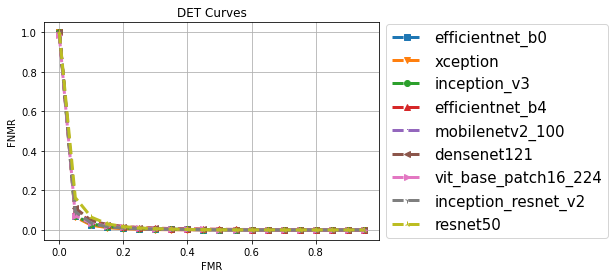

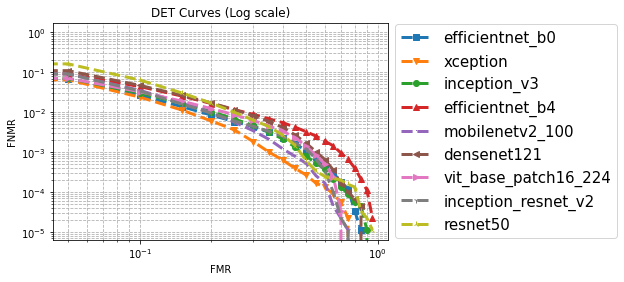

In [168]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_ndiris_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models_all = []
stats_all = []
models = data['models']
stats = data['stats']
for model, stat in zip(models, stats):
    if 'all' in model:
        models_all.append('_'.join(model.split('_')[:-1]))
        stats_all.append(stat)

plt_det_curve(stats_all, models_all, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [181]:
# plt_distributions(stats_all, models_all, hformat=False, bins=100,
#                     lgf_size=15, save_plots=False, dpi=None,
#                     save_path='', ext='.png')  

In [182]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_casia_iris_lamp_subject_report.csv', header=1)
df = df.iloc[:-15]


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : CASIA Iris Lamp, Test : CASIA Iris Lamp', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric')
fig.update_yaxes(matches=None)
fig.show()

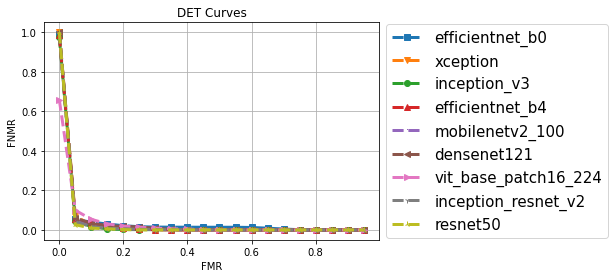

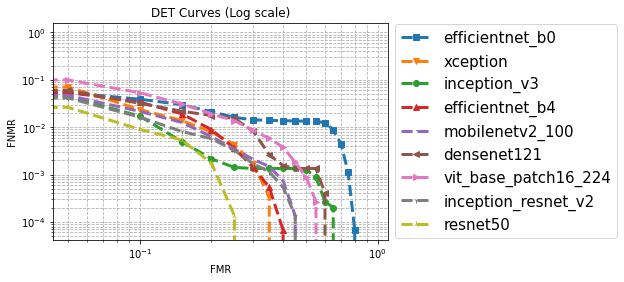

In [171]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_casia_iris_lamp_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models = data['models']
stats = data['stats']

plt_det_curve(stats, models, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [183]:
# plt_distributions(stats_all, models_all, hformat=False, bins=100,
#                     lgf_size=15, save_plots=False, dpi=None,
#                     save_path='', ext='.png')  

In [184]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_casia_iris_syn_subject_report.csv', header=1)
df = df.iloc[:-15]


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : CASIA Iris Synthetic, Test : CASIA Iris Synthetic', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric')
fig.update_yaxes(matches=None)
fig.show()

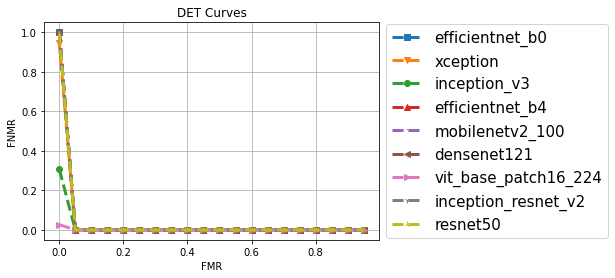

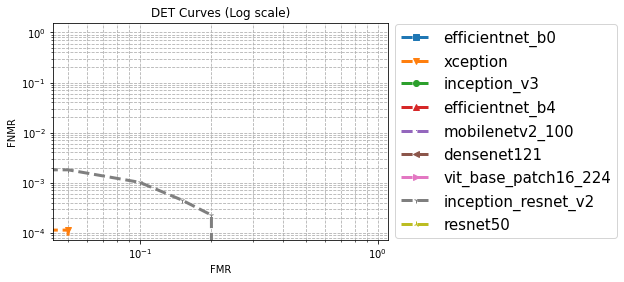

In [173]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_casia_iris_syn_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models = data['models']
stats = data['stats']

plt_det_curve(stats, models, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [185]:
# plt_distributions(stats_all, models_all, hformat=False, bins=100,
#                     lgf_size=15, save_plots=False, dpi=None,
#                     save_path='', ext='.png')  

In [186]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_casia_iris_thousand_subject_report.csv', header=1)
df = df.iloc[:-15]


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : CASIA Iris Thousand, Test : CASIA Iris Thousand', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric')
fig.update_yaxes(matches=None)
fig.show()

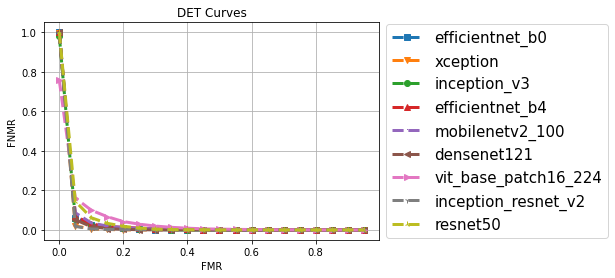

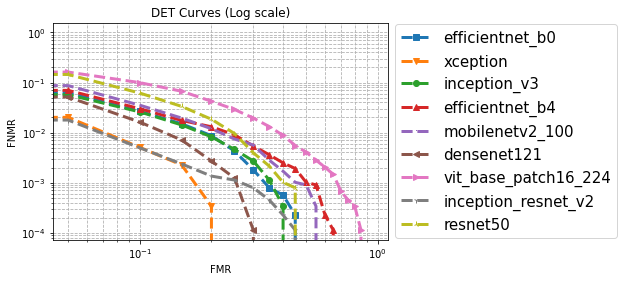

In [175]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_casia_iris_thousand_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models = data['models']
stats = data['stats']
plt_det_curve(stats, models, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [187]:
# plt_distributions(stats_all, models_all, hformat=False, bins=100,
#                     lgf_size=15, save_plots=False, dpi=None,
#                     save_path='', ext='.png')  

In [188]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_face_nir_subject_report.csv', header=1)
df = df.iloc[:-15]

df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : Notredame Face NIR, Test : Notredame Face NIR', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric', color='Gender')
fig.update_yaxes(matches=None)
fig.show()

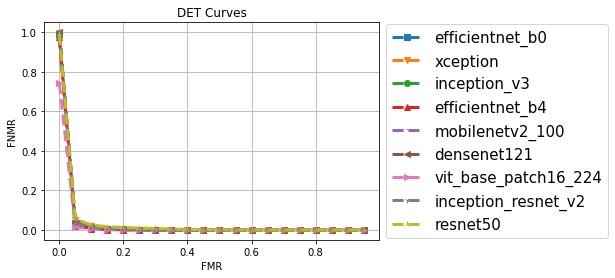

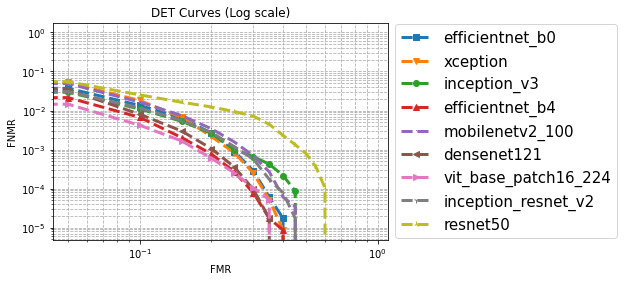

In [190]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_face_nir_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models_all = []
stats_all = []
models = data['models']
stats = data['stats']
for model, stat in zip(models, stats):
    if 'all' in model:
        models_all.append('_'.join(model.split('_')[:-1]))
        stats_all.append(stat)

plt_det_curve(stats_all, models_all, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [1]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_face_rgb_subject_report.csv', header=1)
df = df.iloc[:-15]

df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : Notredame Face RGB, Test : Notredame Face RGB', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric', color='Gender')
fig.update_yaxes(matches=None)
fig.show()

UnboundLocalError: local variable 'fig' referenced before assignment

In [114]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_face_rgb_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models_all = []
stats_all = []
models = data['models']
stats = data['stats']
for model, stat in zip(models, stats):
    if 'all' in model:
        models_all.append('_'.join(model.split('_')[:-1]))
        stats_all.append(stat)

plt_det_curve(stats_all, models_all, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_face_rgb_subject_stats.pickle'

In [88]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_ocular_nir_subject_report.csv', header=1)
df = df.iloc[:-15]

df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : Notredame Ocular NIR, Test : Notredame Ocular NIR', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric', color='Gender')
fig.update_yaxes(matches=None)
fig.show()

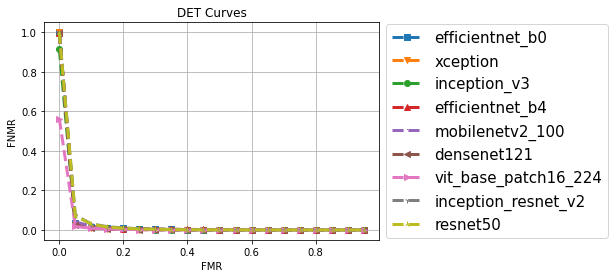

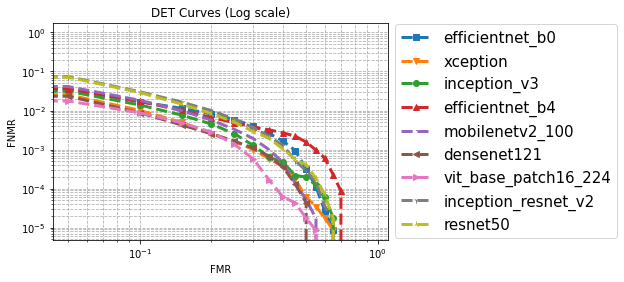

In [115]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_ocular_nir_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models_all = []
stats_all = []
models = data['models']
stats = data['stats']
for model, stat in zip(models, stats):
    if 'all' in model:
        models_all.append('_'.join(model.split('_')[:-1]))
        stats_all.append(stat)

plt_det_curve(stats_all, models_all, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [89]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_ocular_rgb_subject_report.csv', header=1)
df = df.iloc[:-15]

df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : Notredame Ocular RGB, Test : Notredame Ocular RGB', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric', color='Gender')
fig.update_yaxes(matches=None)
fig.show()

In [116]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_ocular_rgb_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models_all = []
stats_all = []
models = data['models']
stats = data['stats']
for model, stat in zip(models, stats):
    if 'all' in model:
        models_all.append('_'.join(model.split('_')[:-1]))
        stats_all.append(stat)

plt_det_curve(stats_all, models_all, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sreeraj/lab/nsf/final_eval/results/across_model_notredame_ocular_rgb_subject_stats.pickle'

In [2]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_polyuiris_nir_subject_report.csv', header=1)
df = df.iloc[:-15]

# df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
# df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : PolyUIris NIR, Test : PolyUIris NIR', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric')
fig.update_yaxes(matches=None)
fig.show()

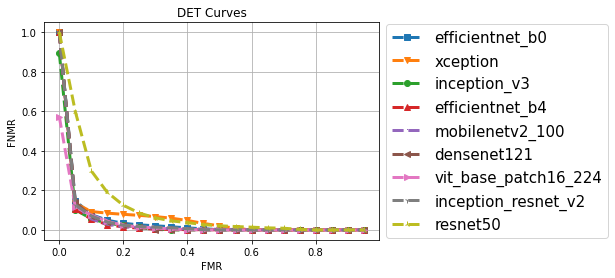

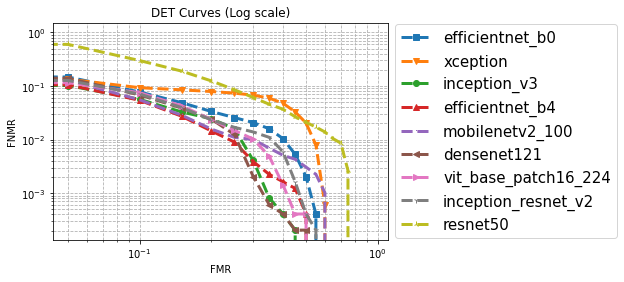

In [118]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_polyuiris_nir_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models = data['models']
stats = data['stats']

plt_det_curve(stats, models, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [3]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_polyuiris_rgb_subject_report.csv', header=1)
df = df.iloc[:-15]

# df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
# df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : PolyUIris RGB, Test : PolyUIris RGB', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric')
fig.update_yaxes(matches=None)
fig.show()

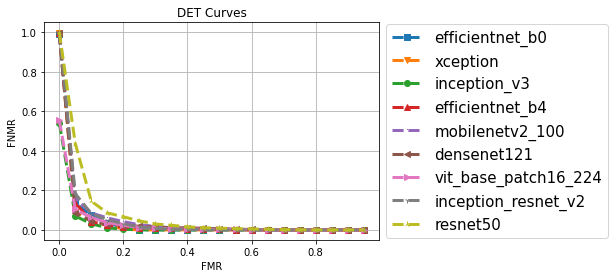

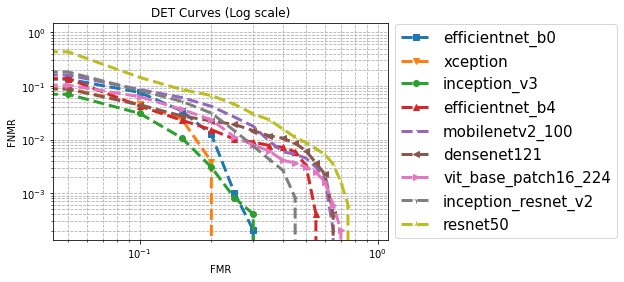

In [119]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_polyuiris_rgb_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models = data['models']
stats = data['stats']

plt_det_curve(stats, models, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [4]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/lab/nsf/final_eval/results/across_model_ufpr_subject_report.csv', header=1)
df = df.iloc[:-15]

df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])
# print(df.head())

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : UFPR, Test : UFPR', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric', color='Gender')
fig.update_yaxes(matches=None)
fig.show()

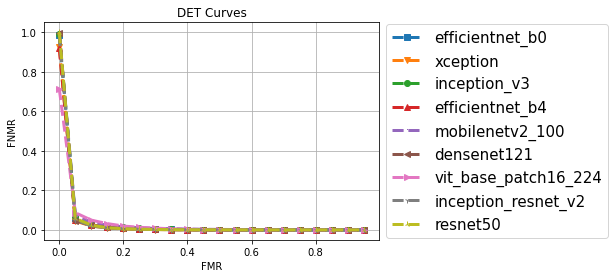

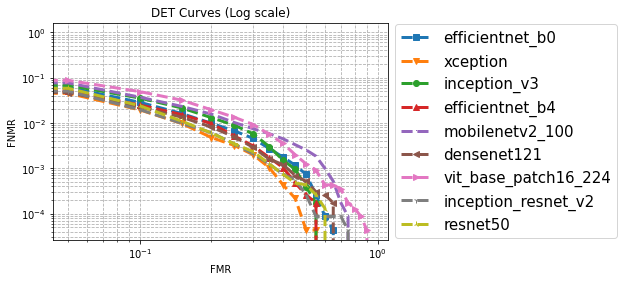

In [120]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_ufpr_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models_all = []
stats_all = []
models = data['models']
stats = data['stats']
for model, stat in zip(models, stats):
    if 'all' in model:
        models_all.append('_'.join(model.split('_')[:-1]))
        stats_all.append(stat)

plt_det_curve(stats_all, models_all, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

In [121]:
import plotly.express as px
import pandas as pd
from copy import deepcopy

df = pd.read_csv('/home/sreeraj/Documents/nfs_final/final_eval/results/across_model_visob_subject_report.csv', header=1)
df = df.iloc[:-15]

df['Gender'] = df['Experiment ID'].apply(lambda x: x.split('_')[-1])
# df = df[df['Gender'] == 'all']
df['Experiment ID'] = df['Experiment ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))


df_auc = deepcopy(df)
df_auc['Value'] = df_auc['AUC']
df_auc['Metric'] = 'AUC'

df_eer = deepcopy(df)
df_eer['Value'] = df_eer['EER']
df_eer['Metric'] = 'EER'

df_dprime = deepcopy(df)
df_dprime['Value'] = df_dprime["Sensitivity index (d')"]
df_dprime['Metric'] = 'dprime'

df_mcc = deepcopy(df)
df_mcc['Value'] = df_mcc['MCC']
df_mcc['Metric'] = 'MCC'

df_jindex = deepcopy(df)
df_jindex['Value'] = df_mcc['J-Index']
df_jindex['Metric'] = 'J-Index'

df = pd.concat([df_auc, df_eer, df_mcc, df_dprime, df_jindex])
# print(df.head())

fig = px.bar(df, x='Experiment ID', y=['Value'], title='Train : VISOB, Test : VISOB', barmode='group', labels={'value': 'Value', 'variable': 'Metrics'},width=1400, height=500, facet_col='Metric', color='Gender')
fig.update_yaxes(matches=None)
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/sreeraj/Documents/nfs_final/final_eval/results/across_model_visob_subject_report.csv'

In [122]:
import pickle 
with open('/home/sreeraj/lab/nsf/final_eval/results/across_model_visob_subject_stats.pickle', 'rb') as f:
    data = pickle.load(f)
models_all = []
stats_all = []
models = data['models']
stats = data['stats']
for model, stat in zip(models, stats):
    if 'all' in model:
        models_all.append('_'.join(model.split('_')[:-1]))
        stats_all.append(stat)

plt_det_curve(stats_all, models_all, line_width=3, lgf_size=15, save_plots=False,
                dpi=None, save_path='', ext='.png', resampling=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sreeraj/lab/nsf/final_eval/results/across_model_visob_subject_stats.pickle'